## Setup environment

In [1]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation import DataHandling 

import numpy as np
import nibabel as nib

In [2]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']


In [10]:

from data_preparation import ExternalRadioSetHandling

data_handler = ExternalRadioSetHandling(data_dir=ga_data_dir, test_ratio=0.2)
train_files, val_files, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")
print(f"Validation data length: {len(val_files)}")
print(f"Train data length: {len(train_files)}")

# To access 'image' keys, iterate through the list
image_images = [file_info['image'] for file_info in test_files]
target_images = [file_info['target'] for file_info in test_files]



Test data length: 37
Validation data length: 29
Train data length: 116


In [3]:
from data_preparation import DataHandling 

data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="ADCM")

train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')
print(len(train_files))
print(len(val_files))
print(len(test_files))

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    spatial_size = (168, 168, 320)
    # spatial_size = (336, 336, 640) # for Fdg data
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)
val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)



129
33
20


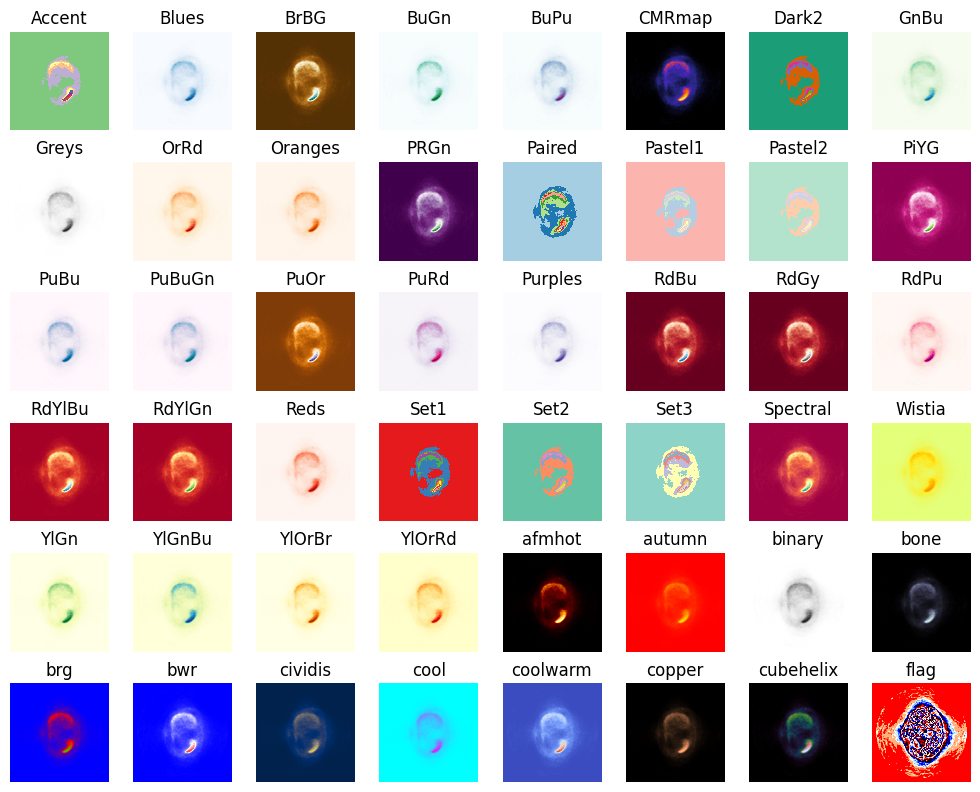

In [11]:
# Since the code execution state was reset, and we do not have the actual image data,
# I will generate a sample image and plot it using the different colormaps requested.

import numpy as np
import matplotlib.pyplot as plt

# Generate a sample image
image = np.random.rand(10, 10)

# List of colormaps to display
colormaps = [
    'Accent', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'Dark2', 'GnBu',
    'Greys', 'OrRd', 'Oranges', 'PRGn', 'Paired', 'Pastel1', 'Pastel2', 'PiYG',
    'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu',
    'RdYlGn', 'Reds', 'Set1', 'Set2', 'Set3', 'Spectral', 'Wistia', 'YlGn',
    'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg',
    'bwr', 'cividis', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth',
    'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg',
    'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'inferno', 'jet', 'magma',
    'nipy_spectral', 'ocean', 'pink', 'plasma', 'prism', 'rainbow', 'seismic',
    'spring', 'summer', 'tab10', 'tab20', 'tab20b', 'tab20c', 'terrain', 'turbo',
    'twilight', 'twilight_shifted', 'viridis', 'winter'
]
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import glob


# Function to display a slice with different colormaps
def plot_image_slice(colormaps, image_slice):
    fig, axes = plt.subplots(6, len(colormaps)//10, figsize=(10, 8))

    for ax, cmap in zip(axes.flatten(), colormaps):
        im = ax.imshow(image_slice, cmap=cmap)
        ax.set_title(cmap)
        ax.axis('off')
        # fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()


# Load one image to demonstrate the colormaps
train_images = sorted(glob.glob(os.path.join(ga_data_dir, "NAC", "*.nii.gz")))
# Just use the first image for the demonstration
nac_img_path = train_images[0] if train_images else None

# Load the image data and take a middle slice to display
if nac_img_path:
    nac_nii = nib.load(nac_img_path)
    nac_img = nac_nii.get_fdata()
    mid_slice = nac_img[:, :, nac_img.shape[2] // 2]

    # Plot the image using the selected colormaps
    plot_image_slice(colormaps, mid_slice)
else:
    print("No images found in the specified directory.")



What is the best epsilon?

In [6]:
def calculate_adcm(nac_img, mac_img, epsilon):

    nac_img = nac_img.astype(np.float32) * 2
    mac_img = mac_img.astype(np.float32) * 5

    # Initialize ADCM with zeros
    adcm = np.zeros_like(mac_img)

    # Calculate ADCM where NASC-PET is greater than epsilon
    mask = nac_img > epsilon
    adcm[mask] = mac_img[mask] / nac_img[mask]

    # Assign MAC values directly where NASC-PET is less than or equal to epsilon
    adcm[~mask] = mac_img[~mask]
    
    return adcm


In [ ]:

from utils import PairFinder

hint4 = 'adcm'
pair_finder_adcm = PairFinder(f'{ga_data_dir}/ADCM', ga_output_dir, hint4)
all_pairs_adcm, c5_pairs_adcm, rest_pairs_adcm = pair_finder_adcm.find_file_pairs()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import glob

class PairFinder:
    def __init__(self, nac_data_dir, mac_data_dir):
        self.nac_data_dir = nac_data_dir
        self.mac_data_dir = mac_data_dir

    def extract_common_name(self, filename):
        # Extracts the base name without extension and specific prefix
        return os.path.splitext(os.path.basename(filename))[0].split('_')[0]

    def find_file_pairs(self):
        nac_files = glob.glob(os.path.join(self.nac_data_dir, '*.nii.gz'))
        mac_files = glob.glob(os.path.join(self.mac_data_dir, '*.nii.gz'))
        nac_dict = {self.extract_common_name(path): path for path in nac_files}
        mac_dict = {self.extract_common_name(path): path for path in mac_files}

        all_pairs = []
        for common_name, nac_path in nac_dict.items():
            mac_path = mac_dict.get(common_name)
            if mac_path:
                all_pairs.append((nac_path, mac_path))
        return all_pairs

def plot_slices(nac_img, mac_img, adcms, epsilons):
    y_middle = nac_img.shape[1] // 2
    n_cols = 2 + len(adcms)
    fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 2, 4))
    axes[0].imshow(nac_img[:, y_middle, :].T, cmap='jet', origin='lower')
    axes[0].set_title('NAC')
    axes[1].imshow(mac_img[:, y_middle, :].T, cmap='jet', origin='lower')
    axes[1].set_title('MAC')
    for i, (adcm, epsilon) in enumerate(zip(adcms, epsilons), start=2):
        axes[i].imshow(adcm[:, y_middle, :].T, cmap='jet', origin='lower')
        axes[i].set_title(f'ADCM Epsilon={epsilon}')
    plt.tight_layout()
    plt.show()

# Configuration
nac_data_dir = f"{ga_data_dir}/NAC"
mac_data_dir = f"{ga_data_dir}/MAC"
pair_finder = PairFinder(nac_data_dir, mac_data_dir)
file_pairs = pair_finder.find_file_pairs()
epsilons = [0.01, 0.001]

# Process each pair
for i, (nac_path, mac_path) in enumerate(file_pairs):
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()
    adcms = [calculate_adcm(nac_img, mac_img, eps) for eps in epsilons]
    plot_slices(nac_img, mac_img, adcms, epsilons)
    if i == 1:  # Stop after processing 2 pairs for demonstration
        break


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import nibabel as nib

# def plot_slices(nac_img, mac_img, adcms, epsilons):
#     # Middle index for the coronal plane (Y-axis)
#     y_middle = nac_img.shape[1] // 2
#     n_cols = 2 + len(adcms)  # 1 column for NAC and MAC, and 1 column for each ADCM
#     fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 2, 4))  # Adjust the figure size accordingly

#     # Plot NAC image
#     axes[0].imshow(nac_img[:, y_middle, :].T, cmap='jet', origin='lower')
#     axes[0].set_title('NAC')

#     # Plot MAC image
#     axes[1].imshow(mac_img[:, y_middle, :].T, cmap='jet', origin='lower')
#     axes[1].set_title('MAC')

#     # Plot each ADCM image
#     for i, (adcm, epsilon) in enumerate(zip(adcms, epsilons), start=2):
#         axes[i].imshow(adcm[:, y_middle, :].T, cmap='jet', origin='lower')
#         axes[i].set_title(f'ADCM Epsilon={epsilon}')

#     plt.tight_layout()
#     plt.show()

# # Define different epsilon values
# # epsilons = [0.1, 0.01, 0.001, 0.0001, 0.00001] 
# epsilons = [0.01, 0.005, 0.003, 0.002, 0.001]
# # epsilons = [ 0.001, 0.0009, 0.0005]
# epsilons = [ 0.001, 0]

# # Loop through the images and plot them
# for i, (nac_path, mac_path) in enumerate(zip(train_images, target_images)):
#     nac_nii = nib.load(nac_path)
#     nac_img = nac_nii.get_fdata()
#     mac_nii = nib.load(mac_path)
#     mac_img = mac_nii.get_fdata()
#     print(nac_path)
#     print(mac_path)
#     adcms = [calculate_adcm(nac_img, mac_img, eps) for eps in epsilons]
    
#     plot_slices(nac_img, mac_img, adcms, epsilons)
#     if i == 2 - 1:  # -1 because indexing starts at 0
#         break


In [ ]:
epsilon = 0

------
# Zero step, Finiding magic number for normalization



In [ ]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

tot_median = []
tot_mean = []
tot_max = []
tot_adcm = []


def calculate_adcm_stat(nac_img, mac_img, epsilon=epsilon):

    nac_img = nac_img.astype(np.float32) * 2
    mac_img = mac_img.astype(np.float32) * 5

    # Initialize ADCM with zeros
    adcm = np.zeros_like(mac_img)

    # Calculate ADCM where NASC-PET is greater than epsilon
    mask = nac_img > epsilon
    adcm[mask] = mac_img[mask] / nac_img[mask]

    # Assign MAC values directly where NASC-PET is less than or equal to epsilon
    adcm[~mask] = mac_img[~mask]

    

    contour = mac_img > 0.3
    adcm_contour = np.zeros_like(adcm)
    adcm_contour[contour] = adcm[contour]

    nonzero_values = adcm_contour[adcm_contour>0]
    adcm_med = np.median(nonzero_values)
    adcm_mean = np.mean(nonzero_values)
    adcm_max = np.max(nonzero_values)


    # Calculate the median of the three median values
    # print('median, mean, max',[adcm_med, np.mean(adcm), np.max(adcm)])
    
    
    return adcm, adcm_med, adcm_mean, adcm_max

    

for nac_path, mac_path in file_pairs:
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()
    
    adcm, adcm_med, adcm_mean, adcm_max = calculate_adcm_stat(nac_img, mac_img)

    tot_median.append(adcm_med)
    tot_mean.append(adcm_mean)
    tot_max.append(adcm_max)
    tot_adcm.append(adcm)

print(f"Overall median: {np.median(tot_median)}, mean: {np.mean(tot_mean)}, max: {np.max(tot_max)}")


In [ ]:
import matplotlib.pyplot as plt

# Plotting histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Median Histogram
axes[0].hist(tot_median, bins=20, color='blue', alpha=0.7, label='Median')
axes[0].set_title('Histogram of Median Values')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Mean Histogram
axes[1].hist(tot_mean, bins=20, color='green', alpha=0.7, label='Mean')
axes[1].set_title('Histogram of Mean Values')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Max Histogram
axes[2].hist(tot_max, bins=20, color='red', alpha=0.7, label='Max')
axes[2].set_title('Histogram of Max Values')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
print('meadian of medians:', np.median(tot_median))
print('meadian of means:', np.median(tot_mean))
print('meadian of maxs:', np.median(tot_max))

print('-------------------')
print('mean of medians:', np.mean(tot_median))
print('mean of means:', np.mean(tot_mean))
print('mean of maxs:', np.mean(tot_max))


from collections import Counter

# Round the values in each list to 1 decimal place
# Round the values in each list to the nearest integer
tot_median_rounded = [int(round(num)) for num in tot_median]
tot_mean_rounded = [int(round(num)) for num in tot_mean]
tot_max_rounded = [int(round(num)) for num in tot_max]


# Using Counter to find the most common value among the rounded values
value_counts = Counter(tot_median_rounded)
most_common_value, frequency = value_counts.most_common(1)[0]

print('-------------')
print('Most common rounded value in medians:', most_common_value)
print('Frequency:', frequency)

value_counts = Counter(tot_mean_rounded)
most_common_value, frequency = value_counts.most_common(1)[0]

print('-------------')
print('Most common rounded value in means:', most_common_value)
print('Frequency:', frequency)


value_counts = Counter(tot_max_rounded)
most_common_value, frequency = value_counts.most_common(1)[0]

print('-------------')
print('Most common rounded value in Maxs:', most_common_value)
print('Frequency:', frequency)

------------

## Normalization ...
I decides to try a list of magic numbers as our magic number for normalization. So -> let's see what would be our new intensity range.

In [ ]:
flattened_adcm = np.concatenate([adcm.flatten() for adcm in tot_adcm])

In [ ]:

def calculate_stats_after_normalization(adcm_values, normalization_values):
    """
    Calculate max and mean of ADCM values after normalization by different values.

    Parameters:
    - adcm_values: Flattened array of all ADCM values from all images.
    - normalization_values: List of values to normalize the ADCM values.

    Returns:
    - A dictionary containing 'max' and 'mean' for each normalization value.
    """
    stats = {}
    for val in normalization_values:
        normalized_adcm = adcm_values / val
        stats[val] = {
            'max': np.max(normalized_adcm),
            'min': np.min(normalized_adcm)
        }
    return stats


normalization_values = [1, 10, 50, 100, 200, 300, 500, 800, 1000, 1785]  # normalization values 
stats_after_normalization = calculate_stats_after_normalization(flattened_adcm, normalization_values)

stats_after_normalization


Then we dicided to test this our network with this ADCM images with this normalization (800: {'max': 35.225, 'min': 0.0}). so ->

------
# First Step, Generating ADCM normalized images

In [ ]:
val = 1
epsilon = 0

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

def calculate_adcm_normalized(nac_img, mac_img, epsilon=epsilon):

    nac_img = nac_img.astype(np.float32) * 2
    mac_img = mac_img.astype(np.float32) * 5

    # Initialize ADCM with zeros
    adcm = np.zeros_like(mac_img)

    # Calculate ADCM where NASC-PET is greater than epsilon
    mask = nac_img > epsilon
    adcm[mask] = mac_img[mask] / nac_img[mask]

    # Assign MAC values directly where NASC-PET is less than or equal to epsilon
    adcm[~mask] = mac_img[~mask]
    
    adcm = adcm / val

    return adcm



def returned_adcm(nac_img, adcm, epsilon=epsilon):

    adcm = adcm * val
    nac_img = nac_img * 2
    
    re_adcm = np.zeros_like(adcm)
    
    # Only perform division where NASC-PET is greater than epsilon
    mask = nac_img > epsilon
    re_adcm[mask] = adcm[mask] * nac_img[mask]
    re_adcm[~mask] = nac_img[~mask]
    
    return re_adcm


# Adjusted function for coronal view
def plot_middle_slice(nac_img, mac_img, adcm, title_prefix=''):
    # Middle index for the coronal plane (Y-axis)
    n = nac_img.shape[1] // 2  # Using the Y dimension size to find the middle slice

    fig, axes = plt.subplots(1, 3, figsize=(8, 12))
    axes[0].imshow(nac_img[:, n, :].T, cmap='jet', origin='lower')
    axes[0].set_title(f'{title_prefix} return_adcm')

    axes[1].imshow(mac_img[:, n, :].T, cmap='jet', origin='lower')
    axes[1].set_title(f'{title_prefix} MAC')

    axes[2].imshow(adcm[:, n, :].T, cmap='jet', origin='lower')
    axes[2].set_title(f'{title_prefix} ADCM')

    plt.show()

i = 0
for nac_path, mac_path in zip(train_images, target_images):
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()

    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()

    norm_adcm = calculate_adcm_normalized(nac_img, mac_img)
    re_adcm = returned_adcm(nac_img, norm_adcm)
    plot_middle_slice(re_adcm, mac_img, norm_adcm, title_prefix="")
    i += 1
    if i == 2:
        break


------
# Second step, Exporting ADCM images

In [ ]:
for nac_path, mac_path in zip(train_images, target_images):
    # Load NAC and MAC images
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()
    
    # Calculate ADCM using the function
    adcm = calculate_adcm_normalized(nac_img, mac_img)
    
    # Use the header from the original MAC image for ADCM image
    adcm_nii = nib.Nifti1Image(adcm.astype(np.float32), mac_nii.affine, mac_nii.header)

    # Construct the path for the output ADCM image
    adcm_filename = os.path.basename(nac_path).replace('.nii.gz', 'adcm') + '.nii.gz'
    adcm_filepath = os.path.join(adcm_dir, adcm_filename)

    # Save the ADCM Nifti image
    nib.save(adcm_nii, adcm_filepath)
    print(f"Saved ADCM image to {adcm_filepath}")


-------------------

Then we have to train our model after it we will back to create a final dl from adcm output. The rest will be done in Inference_adcm.ipynb.
Just to visualize you can use the rest.

In [4]:
import os
import glob
import nibabel as nib
from vis import plot_adcm_final_coronal, plot_adcm_final_trans
from utils import calculate_dl_mac, extract_id


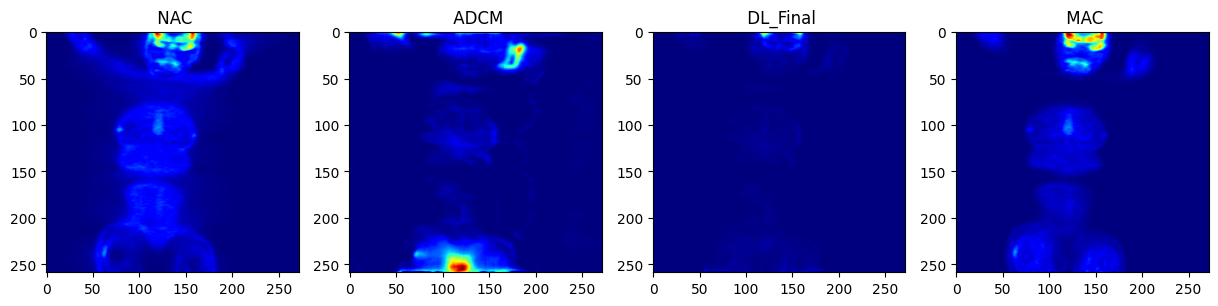

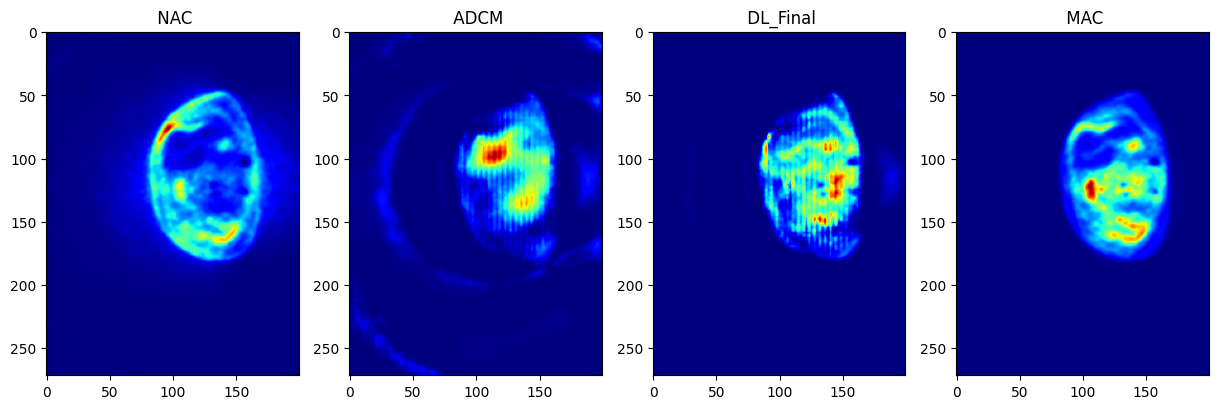

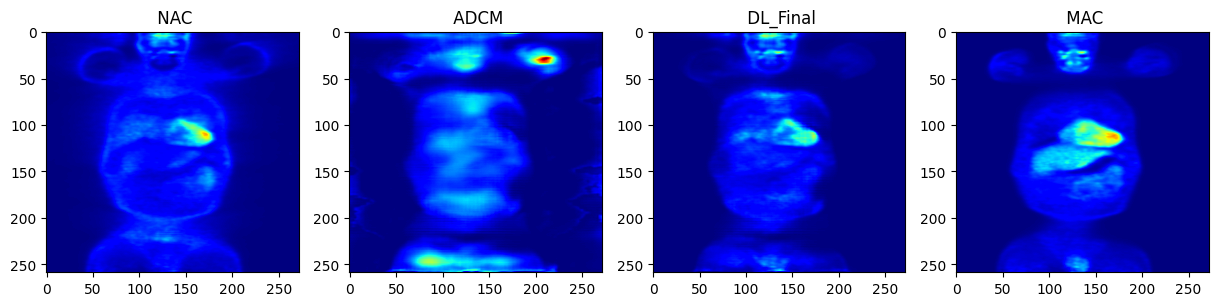

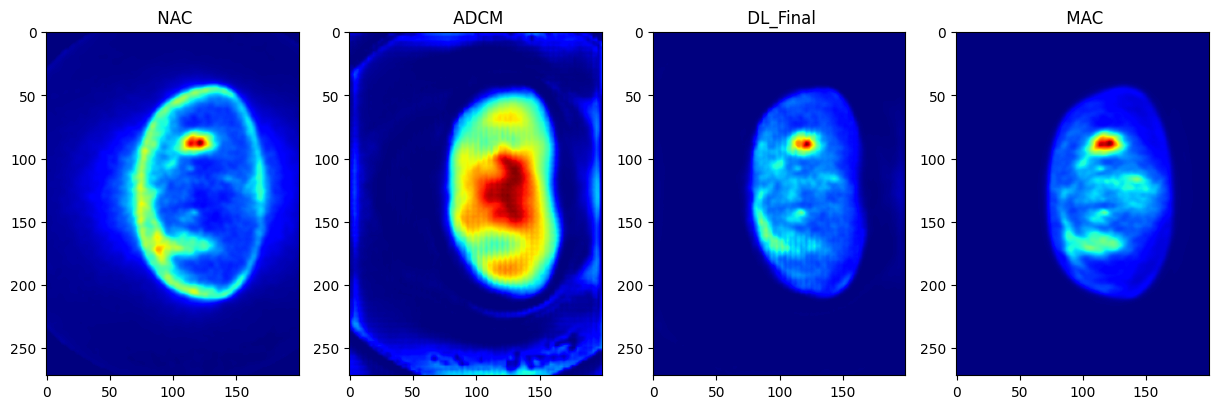

In [7]:
# hint = 'dl_adcm_3_29_v2'
hint_in = 'adcm_4_26'
hint_out = 'final_4_26'
val = 50

nac_images = sorted(glob.glob(os.path.join(fdg_data_dir, "NAC", "*.nii.gz")))
mac_images = sorted(glob.glob(os.path.join(fdg_data_dir, "MAC", "*.nii.gz")))
dl_adcm_images = sorted(glob.glob(os.path.join(fdg_output_dir, f'**/*{hint_in}.nii.gz'), recursive=True))

# Create a dictionary to map identifiers to DL ADCM image paths
dl_adcm_dict = {extract_id(filepath): filepath for filepath in dl_adcm_images}
mac_dict = {extract_id(filepath): filepath for filepath in mac_images}

# Create pairs by matching the NAC image identifiers with those in the DL ADCM and MAC dictionaries
paired_images = [(nac_img, dl_adcm_dict[extract_id(nac_img)], mac_dict[extract_id(nac_img)]) for nac_img in nac_images if extract_id(nac_img) in dl_adcm_dict]

i = 0
for nac_path, dl_adcm_path, mac_path in paired_images:
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()


    dl_adcm_nii = nib.load(dl_adcm_path)
    dl_adcm_im = dl_adcm_nii.get_fdata()
    
    dl_final = calculate_dl_mac(nac_img, dl_adcm_im, val)
    
    # Plotting the middle slice from the NAC, MAC, and ADCM images
    plot_adcm_final_coronal(nac_img, dl_adcm_im, dl_final, mac_img, n=85, title_prefix="")
    plot_adcm_final_trans(nac_img, dl_adcm_im, dl_final, mac_img, title_prefix="")
    i += 1
    if i == 2:
        break


In [54]:
import nibabel as nib
import numpy as np


# Loop through each set of image paths
for idx, (nac_path, dl_adcm_path, mac_path) in enumerate(paired_images):
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()

    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()

    max_value_mac = mac_img.max()  # Find the maximum value in the MAC image
    print(f"Maximum value in MAC Image {idx}: {max_value_mac}")
    
    dl_adcm_nii = nib.load(dl_adcm_path)
    dl_adcm_img = dl_adcm_nii.get_fdata()

    # Apply your calculation to get the final DL image
    dl_final_img = calculate_dl_mac(nac_img, dl_adcm_img, val)  # Ensure `val` is properly defined
    dl_final_img_clipped = np.clip(dl_final_img, a_min=None, a_max=max_value_mac)



    max_positions = np.where(mac_img == max_value_mac)
    corresponding_dl_values = dl_final_img_clipped[max_positions]
    sorted_dl_values = np.sort(corresponding_dl_values)[::-1]
    print(f"Corresponding DL values at MAC max positions for Image {idx}: {sorted_dl_values}")

    print("_______________________")

Maximum value in MAC Image 0: 21.75600052239937
Corresponding DL values at MAC max positions for Image 0: [21.75600052 21.75600052 21.75600052 ...  0.57561128  0.4071491
  0.05577801]
_______________________
Maximum value in MAC Image 1: 33.08188196647557
Corresponding DL values at MAC max positions for Image 1: [33.08188197 33.08188197 33.08188197 ... 14.0955088  13.848035
 12.31748581]
_______________________
Maximum value in MAC Image 2: 20.0926155907328
Corresponding DL values at MAC max positions for Image 2: [20.09261559 20.09261559 20.09261559 ...  0.          0.
  0.        ]
_______________________
Maximum value in MAC Image 3: 27.830128857671415


KeyboardInterrupt: 

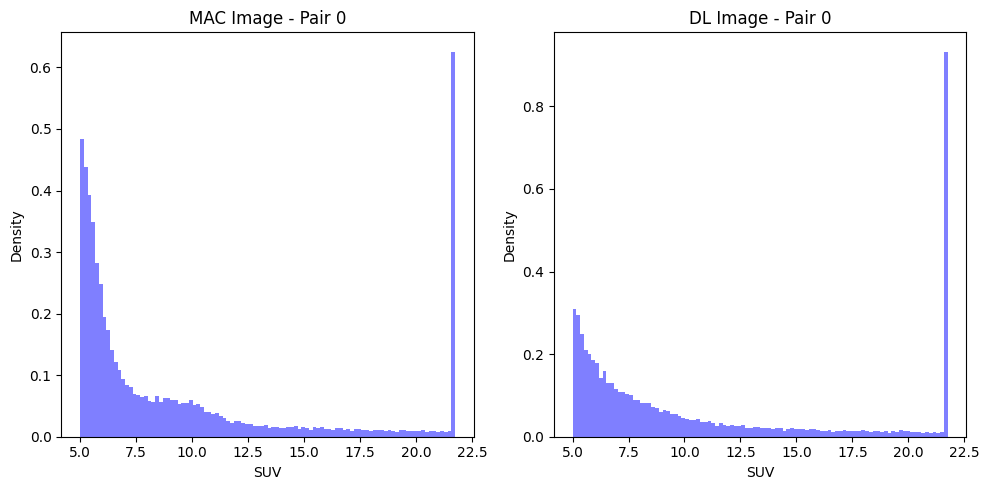

In [58]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def plot_histograms(data, title, ax):
    """ Utility function to plot histogram excluding zeros """
    filtered_data = data[data > 5].ravel()  # Explicitly filter out values <= 0.3
    if filtered_data.size > 0:  # Check if there are any non-zero entries
        ax.hist(filtered_data, bins=100, alpha=0.5, color='blue', density=True)
        ax.set_title(title)
        ax.set_xlabel('SUV')
        ax.set_ylabel('Density')  # We're using density=True for the histogram
    else:
        ax.text(0.5, 0.5, 'No non-zero data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# Assuming paired_images is a list of tuples
for idx, (nac_path, dl_adcm_path, mac_path) in enumerate(paired_images):
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()

    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()
   
    dl_adcm_nii = nib.load(dl_adcm_path)
    dl_adcm_img = dl_adcm_nii.get_fdata()

    dl_final_img = calculate_dl_mac(nac_img, dl_adcm_img, val=50)  # Assuming `val` is 2 for this example
    max_value_mac = mac_img.max()
    dl_final_img_clipped = np.clip(dl_final_img, a_min=None, a_max=max_value_mac)

    # Plot each pair separately
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the size as needed
    plot_histograms(mac_img, f'MAC Image - Pair {idx}', axs[0])
    plot_histograms(dl_final_img_clipped, f'DL Image - Pair {idx}', axs[1])

    plt.tight_layout()
    plt.show()
    break


------------

In [1]:
adcm = "/students/2023-2024/master/Shahpouri/DATA/Ga-PET/ADCM/001093_C1_RZ_adcm.nii.gz"
nac = "/students/2023-2024/master/Shahpouri/DATA/Ga-PET/NAC/001093_C1_RZ_.nii.gz"
mac = "/students/2023-2024/master/Shahpouri/DATA/Ga-PET/MAC/001093_C1_RZ_.nii.gz"

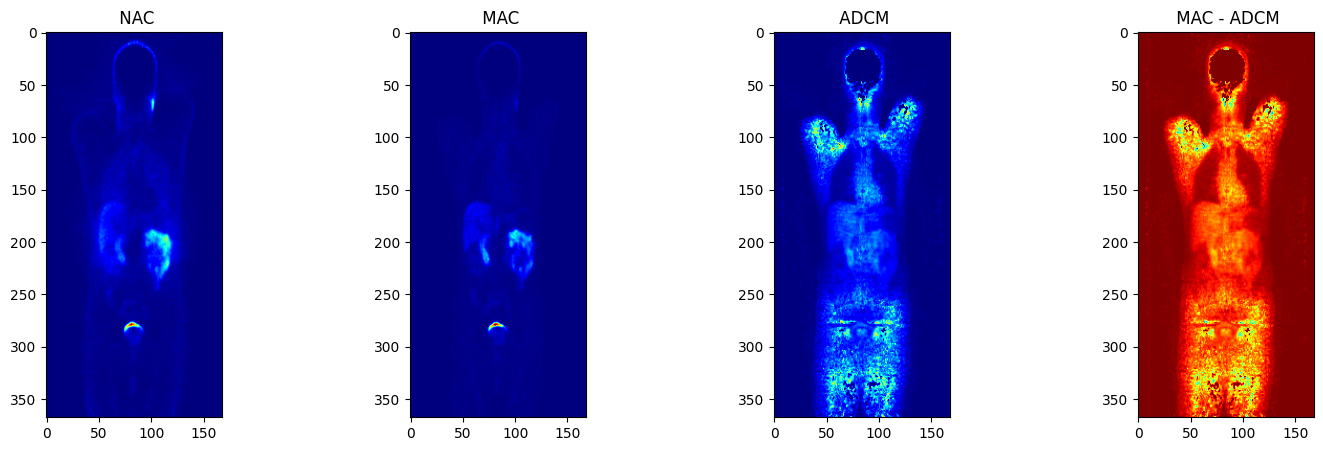

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

def plot_adcm_final_coronal(nac_img, mac_images, dl_adcm_im, n, title_prefix=''):
    
    # Calculate the difference between MAC and ADCM
    mac_minus_adcm = mac_images - dl_adcm_im
    
    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    # NAC image
    axes[0].imshow(np.rot90(nac_img[:, n, :]), cmap='jet')
    axes[0].set_title(f'{title_prefix} NAC')

    
    # MAC image
    axes[1].imshow(np.rot90(mac_images[:, n, :]), cmap='jet')
    axes[1].set_title(f'{title_prefix} MAC')
    
        # ADCM image
    axes[2].imshow(np.rot90(dl_adcm_im[:, n, :]), cmap='jet')
    axes[2].set_title(f'{title_prefix} ADCM')
    
    # MAC - ADCM difference
    axes[3].imshow(np.rot90(mac_minus_adcm[:, n, :]), cmap='jet')
    axes[3].set_title(f'{title_prefix} MAC - ADCM')
    
    plt.show()

# Load the images using nibabel
adcm_img = nib.load("/students/2023-2024/master/Shahpouri/DATA/Ga-PET/ADCM/001093_C1_RZ_adcm.nii.gz").get_fdata()
nac_img = nib.load("/students/2023-2024/master/Shahpouri/DATA/Ga-PET/NAC/001093_C1_RZ_.nii.gz").get_fdata()
mac_img = nib.load("/students/2023-2024/master/Shahpouri/DATA/Ga-PET/MAC/001093_C1_RZ_.nii.gz").get_fdata()



# Select the slice number (adjust as needed)
n_slice = 85

# Plot the images
plot_adcm_final_coronal(nac_img, mac_img, adcm_img, n_slice, title_prefix='')


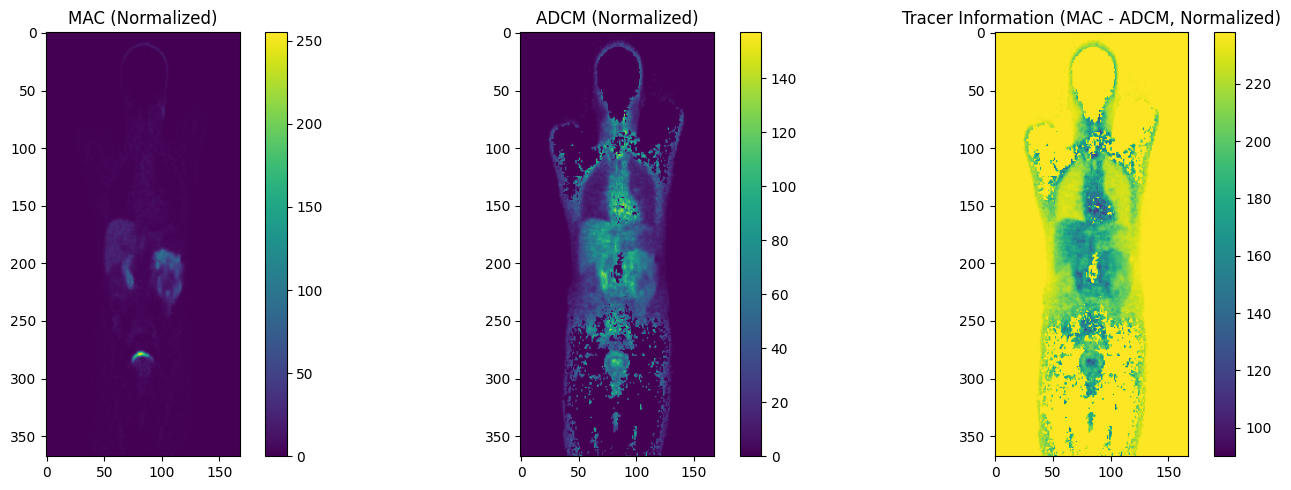

In [14]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def calculate_adcm(nac_img, mac_img, epsilon):
    nac_img = nac_img.astype(np.float32) * 2
    mac_img = mac_img.astype(np.float32) * 5

    # Initialize ADCM with zeros
    adcm = np.zeros_like(mac_img)

    # Calculate ADCM where NASC-PET is greater than epsilon
    mask = nac_img > epsilon
    adcm[mask] = mac_img[mask] / nac_img[mask]

    # Assign MAC values directly where NASC-PET is less than or equal to epsilon
    adcm[~mask] = mac_img[~mask]
    
    return adcm

def normalize_image(image):
    """Normalize image data to the range [0, 255] for display."""
    image_min, image_max = np.min(image), np.max(image)
    if image_max > image_min:  # Avoid division by zero
        image = (image - image_min) / (image_max - image_min) * 255
    return image.astype(np.uint8)

def extract_tracer_information(mac_img, adcm_img):
    mac_img = mac_img.astype(np.float32) * 5
    tracer_info = mac_img - adcm_img
    return tracer_info

# Load the images using nibabel
nac_img = nib.load("/students/2023-2024/master/Shahpouri/DATA/Ga-PET/NAC/001093_C1_RZ_.nii.gz").get_fdata()
mac_img = nib.load("/students/2023-2024/master/Shahpouri/DATA/Ga-PET/MAC/001093_C1_RZ_.nii.gz").get_fdata()

# Set an epsilon value (you may need to tune this based on your data)
epsilon = 0.01

# Calculate ADCM
adcm_img = calculate_adcm(nac_img, mac_img, epsilon)

# Extract tracer-related information
tracer_info = extract_tracer_information(mac_img, adcm_img)

# Normalize images for display
normalized_mac_img = normalize_image(mac_img)
normalized_adcm_img = normalize_image(adcm_img)
normalized_tracer_info = normalize_image(tracer_info)

# Visualization for a specific slice
# Visualization for a specific slice
n_slice = 85
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAC image
img1 = axes[0].imshow(np.rot90(normalized_mac_img[:, n_slice, :]))
axes[0].set_title('MAC (Normalized)')
fig.colorbar(img1, ax=axes[0])

# ADCM image
img2 = axes[1].imshow(np.rot90(normalized_adcm_img[:, n_slice, :]))
axes[1].set_title('ADCM (Normalized)')
fig.colorbar(img2, ax=axes[1])

# Tracer Information image
img3 = axes[2].imshow(np.rot90(normalized_tracer_info[:, n_slice, :]))
axes[2].set_title('Tracer Information (MAC - ADCM, Normalized)')
fig.colorbar(img3, ax=axes[2])

plt.tight_layout()
plt.show()
